In [78]:
import numpy as np
import pandas as pd

#전처리&모델
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#모델
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

#시각화
import seaborn as sns

#기타
import warnings
warnings.filterwarnings('ignore')

# 지수표현 수정
pd.options.display.float_format = '{:.3f}'.format

In [79]:
df = pd.read_csv("C:/Users/김지희/Downloads/fog_train.csv", index_col=0)
df.columns = [col.replace('fog_train.', '') for col in df.columns]

## year열 클래스(I,J,K) 수치화

In [80]:
# year열 I,J,K 순으로 0,1,2로 맵핑
df['year'] = df['year'].map({'I': 0, 'J': 1, 'K': 2})
df['year'].value_counts()

0    1054060
2    1051200
1    1051199
Name: year, dtype: int64

## 20개 지점을 5개의 지역으로 수치화 및 2번 지역 추출

In [81]:
# 첫 글자를 추출하여 새로운 열 생성
df['first_letter'] = df['stn_id'].str[0]

# 알파벳 순서에 따라 번호를 부여
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['first_letter'].unique()))}
df['stn_id'] = df['first_letter'].map(alphabet_order)
df.drop(columns=['first_letter'], inplace=True)

df['stn_id'].value_counts()

0    1262584
1     631292
3     473469
4     473468
2     315646
Name: stn_id, dtype: int64

In [82]:
# 2번 지역만 추출
df2 = df[df['stn_id'].isin([2])]
df2['stn_id'].value_counts()

2    315646
Name: stn_id, dtype: int64

## x(독립변수) 결측값 대체
#### year, month, day, time, minute, re, vis1, class 제외
> **선형보간법** 사용

In [83]:
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df2[numeric_cols] = df2[numeric_cols].replace(-99.9, np.nan)

# 선형보간법을 이용하여 NaN값 처리
df2[numeric_cols] = df2[numeric_cols].interpolate(method='linear')

## re(0:무강수, 1:강수) 결측값 대체
> **직전값** 사용 (결측치 앞뒤)

In [84]:
df2['re'].replace(-99.9, np.nan, inplace=True)
df2['re'] = df2['re'].ffill()
df2['re'] = df2['re'].bfill()

df2['re'].value_counts()

0.000    300262
1.000     15384
Name: re, dtype: int64

## 이상치 탐지 및 독립변수 이상치 대체
> 이상치 탐지: **shewhart** 사용

> 이상치 대체: **선형보간법** 사용 (양방향)

ws10_deg - 이상치 개수: 0


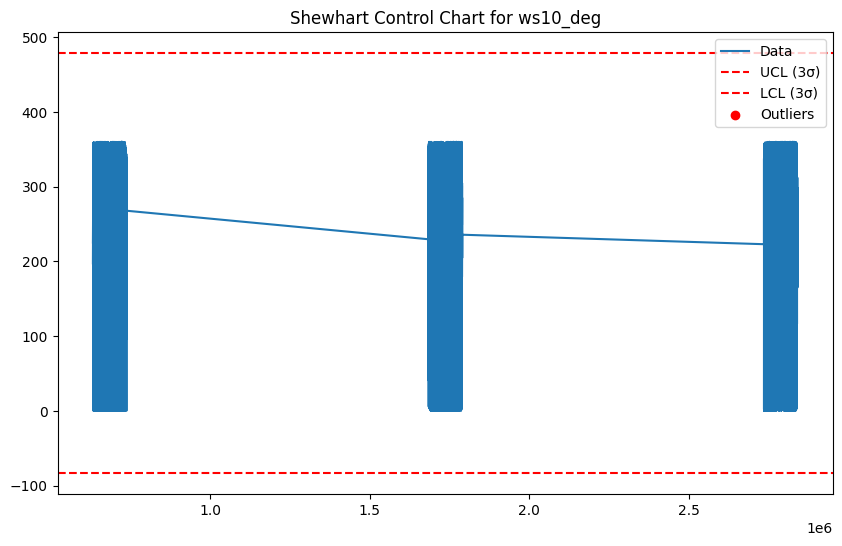

ws10_ms - 이상치 개수: 2512


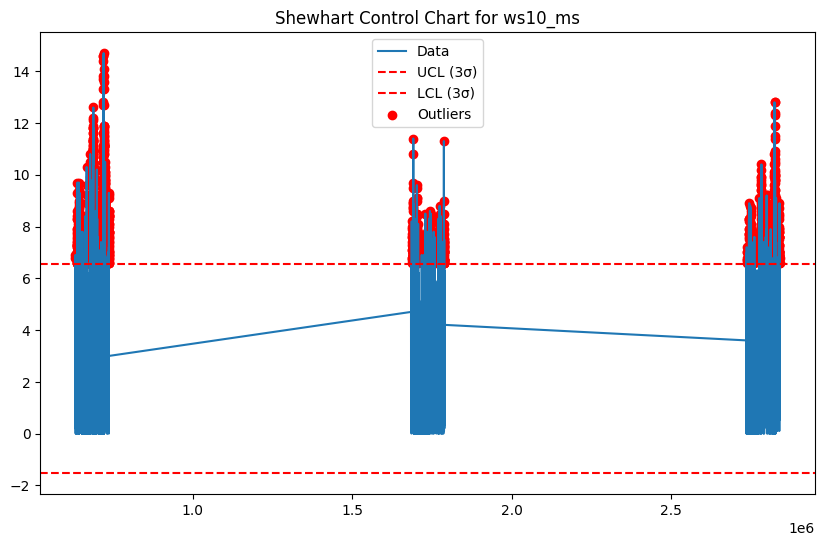

ta - 이상치 개수: 32


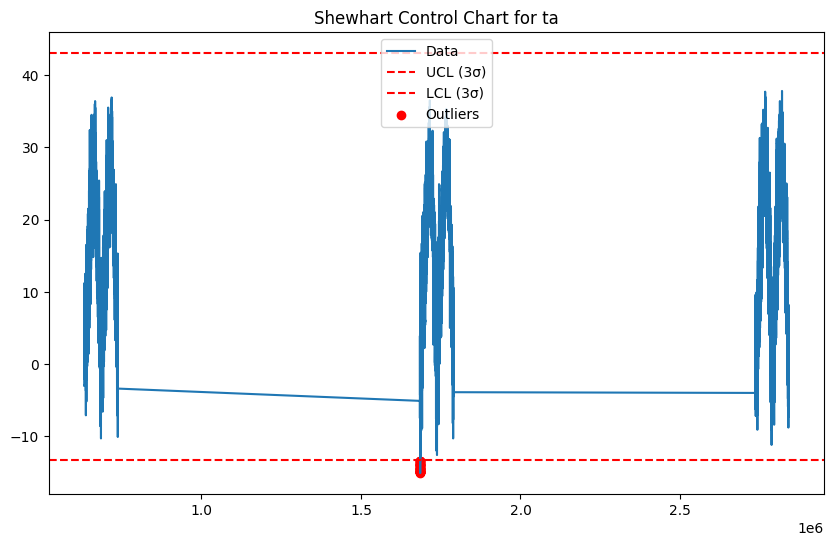

hm - 이상치 개수: 0


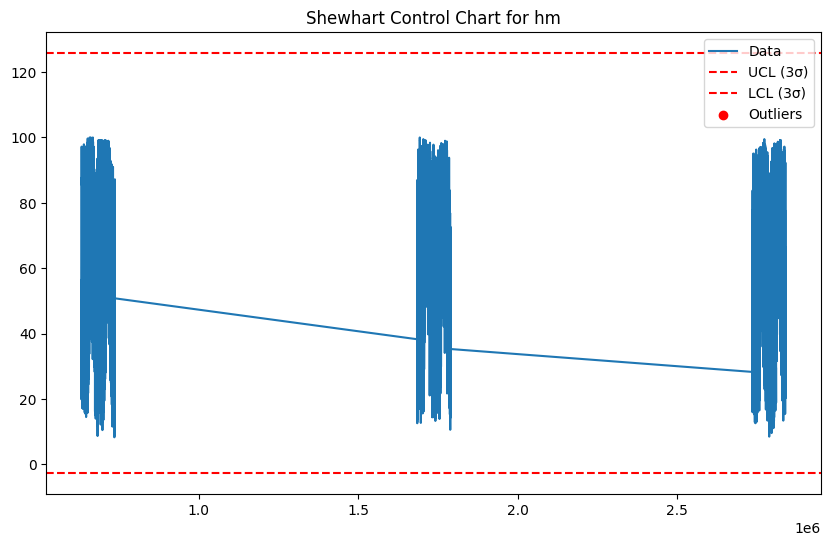

sun10 - 이상치 개수: 2641


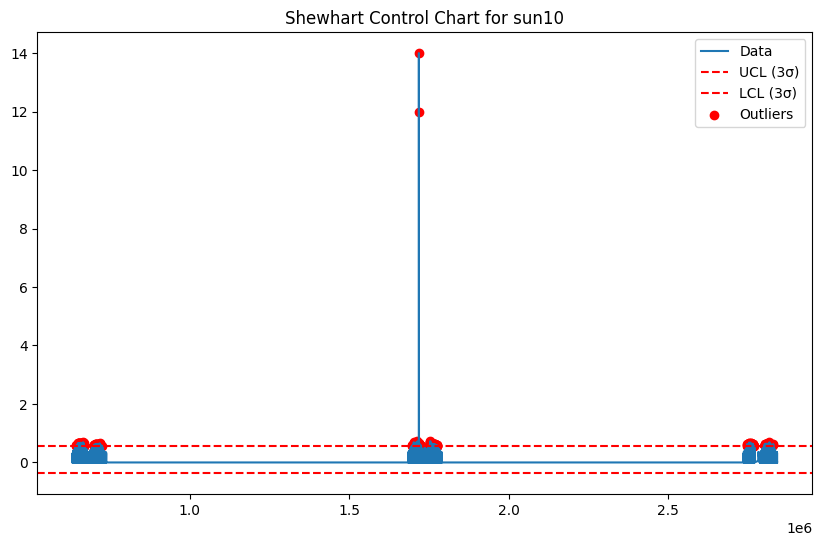

ts - 이상치 개수: 1397


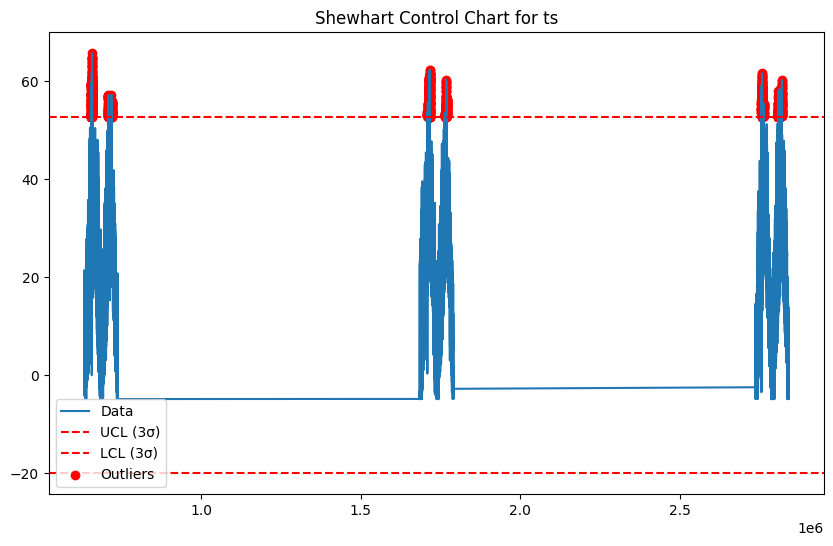

ws10_deg 이상치:
Series([], Name: ws10_deg, dtype: float64)

ws10_ms 이상치:
632540    6.800
632673    6.900
633496    6.800
634241    6.900
637184    6.600
           ... 
2839903   7.000
2839904   7.800
2839921   7.000
2840987   6.800
2840989   6.600
Name: ws10_ms, Length: 2512, dtype: float64

ta 이상치:
1685814   -13.400
1685815   -13.400
1685816   -13.500
1685817   -13.700
1685818   -13.800
1685819   -13.900
1685820   -14.000
1685821   -14.000
1685822   -14.100
1685823   -14.100
1685824   -14.400
1685825   -14.500
1685826   -14.600
1685827   -14.700
1685828   -14.800
1685829   -14.900
1685830   -14.900
1685831   -15.000
1685832   -15.100
1685833   -15.000
1685834   -15.000
1685835   -14.900
1685836   -14.900
1685837   -14.900
1685838   -14.800
1685839   -14.600
1685840   -14.500
1685841   -14.400
1685842   -14.400
1685843   -14.000
1685844   -13.800
1685845   -13.400
Name: ta, dtype: float64

hm 이상치:
Series([], Name: hm, dtype: float64)

sun10 이상치:
644171    0.570
644172    0.580
646769   

In [85]:
import matplotlib.pyplot as plt

# 이상치 탐지 함수
def detect_outliers_shewhart(data):
    mean = data.mean()
    std = data.std()
    ucl = mean + 3 * std
    lcl = mean - 3 * std
    outliers = data[(data > ucl) | (data < lcl)]
    return outliers, ucl, lcl

# 각 열에 대해 이상치 탐지 및 시각화
outliers_dict = {}
for col in numeric_cols:
    outliers, ucl, lcl = detect_outliers_shewhart(df2[col])
    outliers_dict[col] = outliers
    print(f'{col} - 이상치 개수: {len(outliers)}')

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(df2[col], label='Data')
    plt.axhline(y=ucl, color='r', linestyle='--', label='UCL (3σ)')
    plt.axhline(y=lcl, color='r', linestyle='--', label='LCL (3σ)')
    plt.scatter(outliers.index, outliers, color='r', label='Outliers')
    plt.title(f'Shewhart Control Chart for {col}')
    plt.legend()
    plt.show()

# 이상치 출력
for col, outliers in outliers_dict.items():
    print(f'{col} 이상치:\n{outliers}\n')

In [86]:
# 이상치 값을 NaN으로 대체하고 선형 보간법으로 채움
for col, outliers in outliers_dict.items():
    df2.loc[outliers.index, col] = np.nan
    df2[col] = df2[col].interpolate(method='linear', limit_direction='both')

# 보간 후 데이터 확인
for col, outliers in outliers_dict.items():
    print(f'{col} 보간 후 데이터:\n{df2[col]}\n')

ws10_deg 보간 후 데이터:
632437    225.200
632438    234.800
632439    230.300
632440    231.800
632441    235.200
            ...  
2841095   259.300
2841096   250.100
2841097   234.700
2841098   235.000
2841099   244.200
Name: ws10_deg, Length: 315646, dtype: float64

ws10_ms 보간 후 데이터:
632437    4.700
632438    3.600
632439    4.600
632440    4.200
632441    4.200
           ... 
2841095   1.700
2841096   2.300
2841097   2.000
2841098   2.400
2841099   2.600
Name: ws10_ms, Length: 315646, dtype: float64

ta 보간 후 데이터:
632437    -3.000
632438    -3.000
632439    -2.700
632440    -2.500
632441    -2.400
           ...  
2841095    1.500
2841096    1.500
2841097    1.500
2841098    1.600
2841099    1.700
Name: ta, Length: 315646, dtype: float64

hm 보간 후 데이터:
632437    26.600
632438    29.100
632439    31.300
632440    33.700
632441    35.300
           ...  
2841095   51.500
2841096   50.800
2841097   50.500
2841098   50.000
2841099   50.300
Name: hm, Length: 315646, dtype: float64

sun10 보간 후

## 월별 계절성을 반영하여 정규화
> **min-max scaler** 사용

In [87]:
# 이슬점 온도 계산 함수
def calculate_dew_point(temperature, humidity):
    # 계산식: T_d = T - ((100 - RH) / 5)
    dew_point = temperature - ((100 - humidity) / 5)
    return dew_point

# 이슬점 온도 파생변수 생성
df2['dew_point'] = calculate_dew_point(df2['ta'], df2['hm'])

# 열의 순서 재정렬
new_columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10',
               'ts', 'dew_point', 'vis1', 'class']

# 데이터프레임 열 재정렬
df2 = df2.reindex(columns=new_columns)
df2

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class
632437,0,1,1,0,10,2,225.200,4.700,-3.000,0.000,26.600,0.000,-4.000,-17.680,20000,4
632438,0,1,1,0,20,2,234.800,3.600,-3.000,0.000,29.100,0.000,-4.000,-17.180,20000,4
632439,0,1,1,0,30,2,230.300,4.600,-2.700,0.000,31.300,0.000,-3.900,-16.440,20000,4
632440,0,1,1,0,40,2,231.800,4.200,-2.500,0.000,33.700,0.000,-3.700,-15.760,20000,4
632441,0,1,1,0,50,2,235.200,4.200,-2.400,0.000,35.300,0.000,-3.700,-15.340,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841095,2,12,31,23,10,2,259.300,1.700,1.500,0.000,51.500,0.000,-2.200,-8.200,20000,4
2841096,2,12,31,23,20,2,250.100,2.300,1.500,0.000,50.800,0.000,-2.100,-8.340,20000,4
2841097,2,12,31,23,30,2,234.700,2.000,1.500,0.000,50.500,0.000,-2.200,-8.400,20000,4
2841098,2,12,31,23,40,2,235.000,2.400,1.600,0.000,50.000,0.000,-2.200,-8.400,20000,4


In [88]:
from sklearn.preprocessing import MinMaxScaler

# 계절별 구분
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df2['season'] = df2['month'].apply(get_season)

# 정규화할 열 지정
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts', 'dew_point']

# 계절별 정규화
scalers = {}
for season in df2['season'].unique():
    scaler = MinMaxScaler()
    mask = df2['season'] == season
    df2.loc[mask, numeric_cols] = scaler.fit_transform(df2.loc[mask, numeric_cols])
    scalers[season] = scaler

# 'season' 열 제거
df2 = df2.drop(columns=['season'])

# 열의 순서 재정렬
new_columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10',
               'ts', 'dew_point', 'vis1', 'class']

# 결과 출력
df2 = df2.reindex(columns=new_columns)
df2

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class
632437,0,1,1,0,10,2,0.626,0.723,0.270,0.000,0.201,0.000,0.020,0.261,20000,4
632438,0,1,1,0,20,2,0.652,0.554,0.270,0.000,0.229,0.000,0.020,0.273,20000,4
632439,0,1,1,0,30,2,0.640,0.708,0.277,0.000,0.253,0.000,0.022,0.291,20000,4
632440,0,1,1,0,40,2,0.644,0.646,0.283,0.000,0.279,0.000,0.027,0.308,20000,4
632441,0,1,1,0,50,2,0.653,0.646,0.285,0.000,0.297,0.000,0.027,0.318,20000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841095,2,12,31,23,10,2,0.720,0.262,0.387,0.000,0.475,0.000,0.061,0.490,20000,4
2841096,2,12,31,23,20,2,0.695,0.354,0.387,0.000,0.468,0.000,0.063,0.487,20000,4
2841097,2,12,31,23,30,2,0.652,0.308,0.387,0.000,0.464,0.000,0.061,0.486,20000,4
2841098,2,12,31,23,40,2,0.653,0.369,0.390,0.000,0.459,0.000,0.061,0.486,20000,4


In [89]:
contains_negative_99_9 = (df2 == -99).any().any()
print(f"Contains -99.9: {contains_negative_99_9}")

Contains -99.9: False


## target(vis1, class) 결측값 대체
> **random forest (seed: 123)** 사용

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# vis1 결측값(-99)을 NaN으로 변환
df2['vis1'].replace(-99, float('nan'), inplace=True)

# vis1 결측값 예측을 위해 'vis1' 외 데이터로 학습
train_data = df2.dropna(subset=['vis1'])
predict_data = df2[df2['vis1'].isna()]

# 독립변수와 종속변수 설정
X_train = train_data.drop(['year', 'month', 'day', 'time', 'minute', 'stn_id', 'vis1', 'class'], axis=1)
y_train = train_data['vis1']

X_predict = predict_data.drop(['year', 'month', 'day', 'time', 'minute', 'stn_id', 'vis1', 'class'], axis=1)

# RandomForestRegressor 모델 학습
rf = RandomForestRegressor(n_estimators=100, random_state=123)
rf.fit(X_train, y_train)

# 결측값 예측
predicted_vis1 = rf.predict(X_predict)

# 예측값으로 결측값 대체
df2.loc[df2['vis1'].isna(), 'vis1'] = predicted_vis1

In [91]:
# vis1이 음수 확인 -> 음수가 없어야 정상
negative_vis1 = df2[df2['vis1'] < 0]
negative_vis1

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,vis1,class


## XGC(시간 있는 버전~)

In [92]:
# 데이터프레임에서 특성과 레이블 분리
X = df2.drop(['day', 'minute', 'stn_id', 'vis1', 'class'], axis=1)  # 특성들
y = df2['class']  # 레이블

In [93]:
# 클래스 값을 0, 1, 2, 3으로 변환
y = y - 1

In [94]:
# 학습 데이터와 테스트 데이터로 나누기 (여기서는 70% 학습, 30% 검증 데이터로 설정)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123)

In [95]:
# XGBoost 모델 생성

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

# 모델 학습
xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_val)

# 평가
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{conf_matrix}')

[01:15:08] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification Report:
              precision    recall  f1-score   support

        -100       0.93      0.29      0.44       268
           0       0.76      0.26      0.39       129
           1       0.62      0.17      0.27       194
           2       0.60      0.13      0.22       196
           3       0.99      1.00      1.00     93907

    accuracy                           0.99     94694
   macro avg       0.78      0.37      0.46     94694
weighted avg       0.99      0.99      0.99     94694

Confusion Matrix:
[[   78     0     0     0   190]
 [    0    34    10     0    85]
 [    0     7    33     8   146]
 [    0     1     4    26   165]
 [    6     3     6     9 9388

In [96]:
# 데이터 분포 확인
unique, counts = np.unique(y_pred, return_counts=True)
print("y_pred 분포:", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("y_val 분포:", dict(zip(unique, counts)))

y_pred 분포: {-100: 84, 0: 45, 1: 53, 2: 43, 3: 94469}
y_val 분포: {-100: 268, 0: 129, 1: 194, 2: 196, 3: 93907}


In [97]:
# # 예측값을 1차원으로 변환
# y_pred = np.squeeze(y_pred)

# H, F, M 계산
H = np.sum((y_val == y_pred) & (y_val != 3))  # Hits
F = np.sum((y_val != y_pred) & (y_pred != 3))  # False Alarms
M = np.sum((y_val != y_pred) & (y_pred == 3))  # Misses

# CSI 계산
CSI = H / (H + F + M)
print(f"검증 데이터 CSI: {CSI}")

검증 데이터 CSI: 0.21085080147965474


-----------------------------------------------------------------------

#**fog_test**

In [98]:
df_test = pd.read_csv("C:/Users/김지희/Downloads/fog_test.csv", index_col=0)
df_test.columns = [col.replace('fog_test.', '') for col in df_test.columns]
df_test

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
1,L,1,1,0,0,AI,329.500,0.600,-2.500,0.000,87.500,0.000,-1.600,NaN
2,L,1,1,0,10,AI,321.800,1.200,-2.500,0.000,88.200,0.000,-1.600,NaN
3,L,1,1,0,20,AI,0.400,0.400,-2.500,0.000,88.600,0.000,-1.700,NaN
4,L,1,1,0,30,AI,323.600,0.700,-2.600,0.000,88.700,0.000,-1.600,NaN
5,L,1,1,0,40,AI,208.400,0.200,-2.600,0.000,89.000,0.000,-1.600,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262796,L,12,31,23,10,ED,338.800,6.100,4.500,0.000,71.300,0.000,1.900,NaN
262797,L,12,31,23,20,ED,335.200,5.800,4.600,0.000,71.400,0.000,1.900,NaN
262798,L,12,31,23,30,ED,337.100,5.300,4.500,0.000,72.100,0.000,1.800,NaN
262799,L,12,31,23,40,ED,322.000,3.700,4.300,0.000,72.500,0.000,1.400,NaN


In [99]:
df_test['year'] = df_test['year'].map({'L': 3})
df_test['year'].value_counts()

3    262800
Name: year, dtype: int64

In [100]:
# 첫 글자를 추출하여 새로운 열 생성
df_test['first_letter'] = df_test['stn_id'].str[0]

# 알파벳 순서에 따라 번호를 부여
alphabet_order = {char: idx for idx, char in enumerate(sorted(df_test['first_letter'].unique()))}
df_test['stn_id'] = df_test['first_letter'].map(alphabet_order)
df_test.drop(columns=['first_letter'], inplace=True)

df_test['stn_id'].value_counts()

0    52560
1    52560
2    52560
3    52560
4    52560
Name: stn_id, dtype: int64

In [101]:
# 2번 지역만 추출
df2 = df[df['stn_id'].isin([2])]
df2['stn_id'].value_counts()

2    315646
Name: stn_id, dtype: int64

In [102]:
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df_test[numeric_cols] = df_test[numeric_cols].replace(-99.9, np.nan)

# 선형보간법을 이용하여 NaN값 처리
df_test[numeric_cols] = df_test[numeric_cols].interpolate(method='linear')

In [103]:
df_test['re'].replace(-99.9, np.nan, inplace=True)
df_test['re'] = df_test['re'].ffill()
df_test['re'] = df_test['re'].bfill()

df_test['re'].value_counts()

0.000    246549
1.000     16251
Name: re, dtype: int64

ws10_deg - 이상치 개수: 0


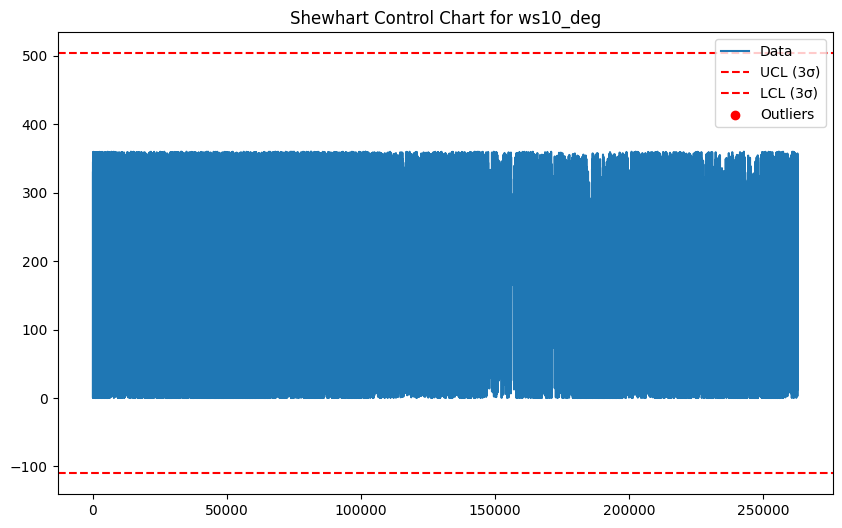

ws10_ms - 이상치 개수: 4063


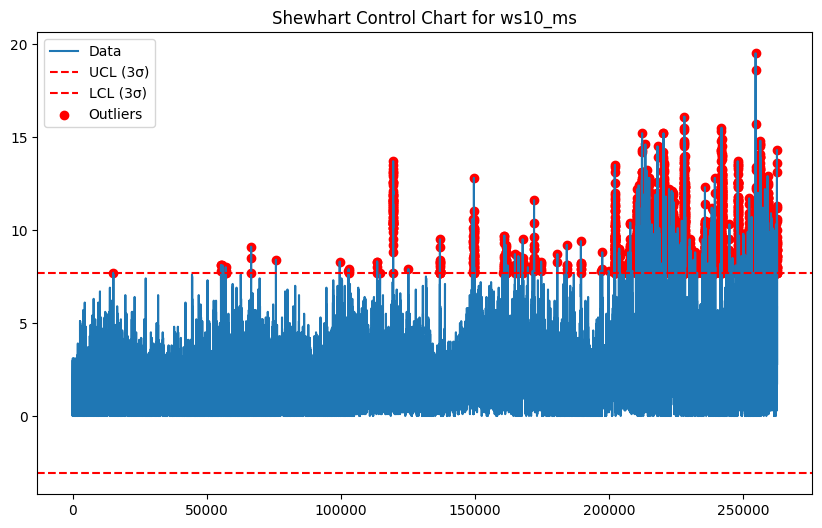

ta - 이상치 개수: 64


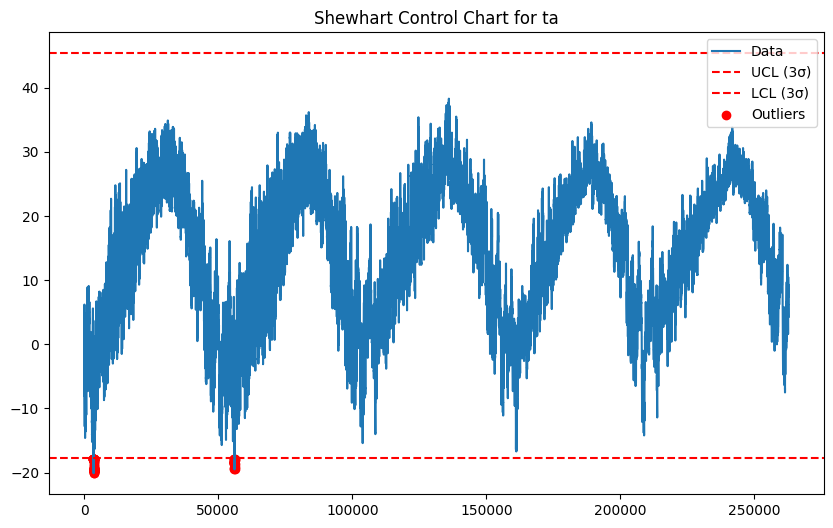

hm - 이상치 개수: 0


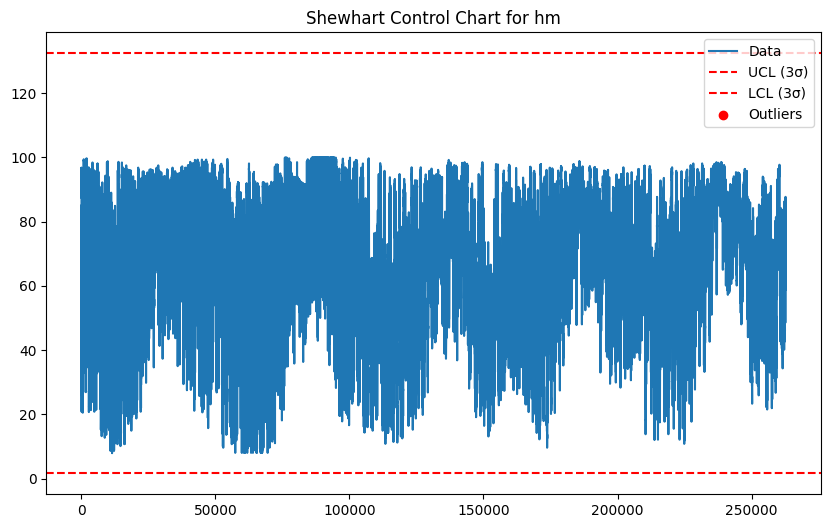

sun10 - 이상치 개수: 2572


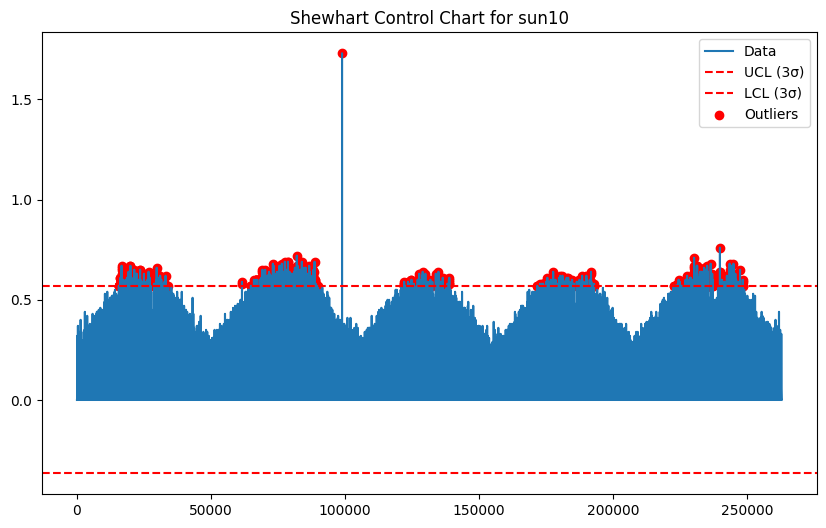

ts - 이상치 개수: 642


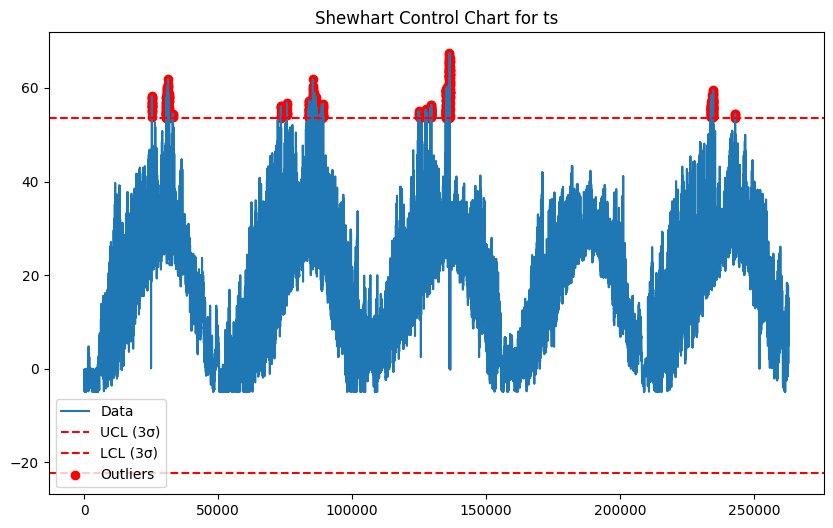

ws10_deg 이상치:
Series([], Name: ws10_deg, dtype: float64)

ws10_ms 이상치:
15226     7.700
55359     7.800
55361     8.100
55368     8.100
55917     8.100
          ...  
262746   11.200
262747    9.300
262769    7.700
262770    9.400
262771   10.500
Name: ws10_ms, Length: 4063, dtype: float64

ta 이상치:
3457    -17.800
3463    -17.800
3464    -17.800
3465    -17.800
3466    -17.800
          ...  
56064   -19.500
56065   -19.100
56066   -18.700
56067   -18.100
56190   -17.800
Name: ta, Length: 64, dtype: float64

hm 이상치:
Series([], Name: hm, dtype: float64)

sun10 이상치:
15626    0.570
15628    0.570
15629    0.570
15631    0.570
16204    0.580
          ... 
247757   0.570
248328   0.570
248330   0.590
248331   0.600
248334   0.570
Name: sun10, Length: 2572, dtype: float64

ts 이상치:
25271    55.300
25272    56.100
25273    56.100
25274    55.000
25275    56.800
          ...  
234661   57.300
242859   53.600
242860   53.900
242861   54.400
242862   54.400
Name: ts, Length: 642, dtype: float64

In [104]:
import matplotlib.pyplot as plt

# 이상치 탐지 함수
def detect_outliers_shewhart(data):
    mean = data.mean()
    std = data.std()
    ucl = mean + 3 * std
    lcl = mean - 3 * std
    outliers = data[(data > ucl) | (data < lcl)]
    return outliers, ucl, lcl

# 각 열에 대해 이상치 탐지 및 시각화
outliers_dict = {}
for col in numeric_cols:
    outliers, ucl, lcl = detect_outliers_shewhart(df_test[col])
    outliers_dict[col] = outliers
    print(f'{col} - 이상치 개수: {len(outliers)}')

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(df_test[col], label='Data')
    plt.axhline(y=ucl, color='r', linestyle='--', label='UCL (3σ)')
    plt.axhline(y=lcl, color='r', linestyle='--', label='LCL (3σ)')
    plt.scatter(outliers.index, outliers, color='r', label='Outliers')
    plt.title(f'Shewhart Control Chart for {col}')
    plt.legend()
    plt.show()

# 이상치 출력
for col, outliers in outliers_dict.items():
    print(f'{col} 이상치:\n{outliers}\n')

In [105]:
# 이상치 값을 NaN으로 대체하고 선형 보간법으로 채움
for col, outliers in outliers_dict.items():
    df_test.loc[outliers.index, col] = np.nan
    df_test[col] = df_test[col].interpolate(method='linear', limit_direction='both')

# 보간 후 데이터 확인
for col, outliers in outliers_dict.items():
    print(f'{col} 보간 후 데이터:\n{df_test[col]}\n')

ws10_deg 보간 후 데이터:
1        329.500
2        321.800
3          0.400
4        323.600
5        208.400
           ...  
262796   338.800
262797   335.200
262798   337.100
262799   322.000
262800    33.600
Name: ws10_deg, Length: 262800, dtype: float64

ws10_ms 보간 후 데이터:
1        0.600
2        1.200
3        0.400
4        0.700
5        0.200
          ... 
262796   6.100
262797   5.800
262798   5.300
262799   3.700
262800   2.800
Name: ws10_ms, Length: 262800, dtype: float64

ta 보간 후 데이터:
1        -2.500
2        -2.500
3        -2.500
4        -2.600
5        -2.600
          ...  
262796    4.500
262797    4.600
262798    4.500
262799    4.300
262800    4.300
Name: ta, Length: 262800, dtype: float64

hm 보간 후 데이터:
1        87.500
2        88.200
3        88.600
4        88.700
5        89.000
          ...  
262796   71.300
262797   71.400
262798   72.100
262799   72.500
262800   73.700
Name: hm, Length: 262800, dtype: float64

sun10 보간 후 데이터:
1        0.000
2        0.000
3       

In [106]:
# 이슬점 온도 계산 함수
def calculate_dew_point(temperature, humidity):
    # 계산식: T_d = T - ((100 - RH) / 5)
    dew_point = temperature - ((100 - humidity) / 5)
    return dew_point

# 이슬점 온도 파생변수 생성
df_test['dew_point'] = calculate_dew_point(df_test['ta'], df_test['hm'])

# 열의 순서 재정렬
new_columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10',
               'ts', 'dew_point', 'class']

# 데이터프레임 열 재정렬
df_test = df_test.reindex(columns=new_columns)
df_test

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,class
1,3,1,1,0,0,0,329.500,0.600,-2.500,0.000,87.500,0.000,-1.600,-5.000,NaN
2,3,1,1,0,10,0,321.800,1.200,-2.500,0.000,88.200,0.000,-1.600,-4.860,NaN
3,3,1,1,0,20,0,0.400,0.400,-2.500,0.000,88.600,0.000,-1.700,-4.780,NaN
4,3,1,1,0,30,0,323.600,0.700,-2.600,0.000,88.700,0.000,-1.600,-4.860,NaN
5,3,1,1,0,40,0,208.400,0.200,-2.600,0.000,89.000,0.000,-1.600,-4.800,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262796,3,12,31,23,10,4,338.800,6.100,4.500,0.000,71.300,0.000,1.900,-1.240,NaN
262797,3,12,31,23,20,4,335.200,5.800,4.600,0.000,71.400,0.000,1.900,-1.120,NaN
262798,3,12,31,23,30,4,337.100,5.300,4.500,0.000,72.100,0.000,1.800,-1.080,NaN
262799,3,12,31,23,40,4,322.000,3.700,4.300,0.000,72.500,0.000,1.400,-1.200,NaN


In [107]:
# 계절별 구분
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df_test['season'] = df_test['month'].apply(get_season)

# 정규화할 열 지정
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts', 'dew_point']

# 계절별 정규화
scalers = {}
for season in df_test['season'].unique():
    scaler = MinMaxScaler()
    mask = df_test['season'] == season
    df_test.loc[mask, numeric_cols] = scaler.fit_transform(df_test.loc[mask, numeric_cols])
    scalers[season] = scaler

# 'season' 열 제거
df_test = df_test.drop(columns=['season'])

# 열의 순서 재정렬
new_columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10',
               'ts', 'dew_point','class']

# 결과 출력
df_test = df_test.reindex(columns=new_columns)
df_test

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,class
1,3,1,1,0,0,0,0.916,0.079,0.398,0.000,0.867,0.000,0.085,0.529,NaN
2,3,1,1,0,10,0,0.894,0.158,0.398,0.000,0.875,0.000,0.085,0.532,NaN
3,3,1,1,0,20,0,0.001,0.053,0.398,0.000,0.879,0.000,0.083,0.534,NaN
4,3,1,1,0,30,0,0.899,0.092,0.395,0.000,0.880,0.000,0.085,0.532,NaN
5,3,1,1,0,40,0,0.579,0.026,0.395,0.000,0.883,0.000,0.085,0.533,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262796,3,12,31,23,10,4,0.941,0.803,0.581,0.000,0.690,0.000,0.176,0.613,NaN
262797,3,12,31,23,20,4,0.931,0.763,0.584,0.000,0.691,0.000,0.176,0.616,NaN
262798,3,12,31,23,30,4,0.937,0.697,0.581,0.000,0.699,0.000,0.174,0.616,NaN
262799,3,12,31,23,40,4,0.895,0.487,0.576,0.000,0.703,0.000,0.163,0.614,NaN


#XGC(시간 있는 버전~)

In [108]:
# 데이터프레임에서 특성과 레이블 분리
X_test = df_test.drop(['day', 'minute', 'stn_id', 'class'], axis=1)

In [109]:
# XGBoost 모델을 사용하여 'class' 예측
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

In [110]:
xgb_model.fit(X_train, y_train)

[01:15:19] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [111]:
y_pred_test = xgb_model.predict(X_test)

In [112]:
# 예측값을 기존 형태로 변환 (예시에서는 예측된 값에 1을 더할 필요가 있을 수 있음)
df_test['class'] = y_pred_test + 1

In [113]:
# 최종 데이터프레임 확인
df_test.head()

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,dew_point,class
1,3,1,1,0,0,0,0.916,0.079,0.398,0.000,0.867,0.000,0.085,0.529,4
2,3,1,1,0,10,0,0.894,0.158,0.398,0.000,0.875,0.000,0.085,0.532,4
3,3,1,1,0,20,0,0.001,0.053,0.398,0.000,0.879,0.000,0.083,0.534,4
4,3,1,1,0,30,0,0.899,0.092,0.395,0.000,0.880,0.000,0.085,0.532,4
5,3,1,1,0,40,0,0.579,0.026,0.395,0.000,0.883,0.000,0.085,0.533,4


In [114]:
df_test['class'].value_counts()

 4     262617
 2        114
-99        68
 3          1
Name: class, dtype: int64

In [116]:
contains_negative_99_9 = (df_test == -99).any().any()
print(f"Contains -99.9: {contains_negative_99_9}")

Contains -99.9: True
